# LDA模型实战常用知识点
之前在公众号里分享过好几次LDA话题模型的，但考虑的问题都比较简单。这次我将分享在这个notebook中，将会对以下问题进行实战：

- 提取话题的关键词
- gridsearch寻找最佳模型参数
- 可视化话题模型
- 预测新输入的文本的话题
- 如何查看话题的特征词组
- 如何获得每个话题的最重要的n个特征词

### 1.导入数据
这里我们使用的20newsgroups数据集

In [1]:
import pandas as pd

df = pd.read_json('newsgroups.json')
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [2]:
df.target_names.unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'rec.motorcycles',
       'misc.forsale', 'comp.os.ms-windows.misc', 'alt.atheism',
       'comp.graphics', 'rec.sport.baseball', 'rec.sport.hockey',
       'sci.electronics', 'sci.space', 'talk.politics.misc', 'sci.med',
       'talk.politics.mideast', 'soc.religion.christian',
       'comp.windows.x', 'comp.sys.ibm.pc.hardware', 'talk.politics.guns',
       'talk.religion.misc', 'sci.crypt'], dtype=object)

### 2.英文清洗数据
1. 使用正则表达式去除邮件和换行等多余空白字符
2. 使用gensim库的simple_preprocess分词，得到词语列表
3. 保留某些词性的词语  https://www.guru99.com/pos-tagging-chunking-nltk.html

### 注意：
nltk和spacy安装配置比较麻烦，可以看这篇文章。  https://dwz.cn/ClPN8iMU
其中nltk语料库和spacy的英文模型均已放置在教程文件夹内~

In [26]:
import nltk
import gensim
from nltk import pos_tag
import re
from nltk.corpus import stopwords

#导入spacy的模型
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clean_text(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text = re.sub('\S*@\S*\s?', '', text) #去除邮件
    text = re.sub('\s+', ' ', text)       #将连续空格、换行、制表符  替换为 空格
    
    #deacc=True可以将某些非英文字母转化为英文字母，例如
    #"Šéf chomutovských komunistů dostal poštou bílý prášek"转化为
    #u'Sef chomutovskych komunistu dostal postou bily prasek'
    words = gensim.utils.simple_preprocess(text, deacc=True)
    #可以在此处加入去停词操作
    stpwords = stopwords.words('english')
    
    #保留词性为'NOUN', 'ADJ', 'VERB', 'ADV'词语
    doc = nlp(' '.join(words)) 
    text = " ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                     for token in doc 
                     if token.pos_ in allowed_postags])
    return text

test = "From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"
clean_text(test)

'where thing subject car be nntp post host rac wam umd edu organization university maryland college park line be wonder anyone out there could enlighten car see other day be door sport car look be late early be call bricklin door be really small addition front bumper be separate rest body be know anyone can tellme model name engine spec year production where car be make history info have funky look car mail thank bring neighborhood lerxst'

In [27]:
df.content = df.content.apply(clean_text)
df.head()

,content,target,target_names
0,where thing subject car be nntp post host rac ...,7,rec.autos
1,guy kuo subject si clock poll final call summa...,4,comp.sys.mac.hardware
10,irwin arnstein subject recommendation duc summ...,8,rec.motorcycles
100,tsung kun chen subject software forsale lot nn...,6,misc.forsale
1000,don lindbergh subject diamond ss win mouse cur...,2,comp.os.ms-windows.misc


### 3. 构建文档词频矩阵 document-word matrix

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#vectorizer = TfidfVectorizer(min_df=10)#单词至少出现在10个文档中
                             
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(df.content)

检查数据的稀疏性,

In [29]:
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, '%')

Sparsicity:  0.9138563473570427 %


### 4.构建LDA模型
使用sklearn库的LatentDirichletAllocation

In [30]:
from sklearn.decomposition import LatentDirichletAllocation

# 构建LDA话题模型
lda_model = LatentDirichletAllocation(n_components=20)              # 话题数
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  #模型参数

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)


模型表现

In [31]:
# 越高越好
print(lda_model.score(data_vectorized))

#训练好的模型的参数
print(lda_model.get_params())

-11868684.751381714
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### 5. 如何找到最佳的话题数
LatentDirichletAllocation中有很多参数，调整参数会使得结果发生变化。为了训练出更好的模型，这里我们使用n_components和learning_decay这两个参数作为示范，设置这两个参数可能的取值范围。

运行时间 半个小时~ 

In [32]:
from sklearn.model_selection import GridSearchCV

# 设置参数搜寻的范围
search_params = {'n_components': [10, 15, 20, 25, 30], 
                 'learning_decay': [.5, .7, .9]}

# 初始化LDA模型
lda = LatentDirichletAllocation()

# 初始化GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# 训练LDA模型
model.fit(data_vectorized)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [33]:
model.cv_results_

{'mean_fit_time': array([76.23844155, 78.47619971, 75.65877469, 92.04278994, 92.47375035,
        70.50102162, 77.17208759, 77.42245611, 78.51173854, 80.36060111,
        64.35273759, 80.74369526, 78.33191927, 97.60522366, 91.52556197]),
 'std_fit_time': array([ 1.90773724,  6.00546298,  2.90480388, 10.82104708,  2.15837996,
         0.91492716,  1.78299082,  0.99124146,  0.88202007,  2.52887488,
         1.42895102,  3.4966494 ,  4.10921772,  8.57965772,  2.97772162]),
 'mean_score_time': array([3.03948617, 3.12327973, 3.17385236, 4.1181256 , 4.14796472,
        2.80464379, 3.00497603, 3.18396346, 3.29176935, 3.34573205,
        2.60685007, 3.05136299, 3.39874609, 3.77345729, 4.19327569]),
 'std_score_time': array([0.29957093, 0.0616576 , 0.13170509, 0.4152717 , 0.58759639,
        0.05777709, 0.17347846, 0.06664403, 0.13021069, 0.12982755,
        0.06256295, 0.13255927, 0.43057235, 0.29978059, 0.44248399]),
 'param_learning_decay': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.5, 0.7, 0.

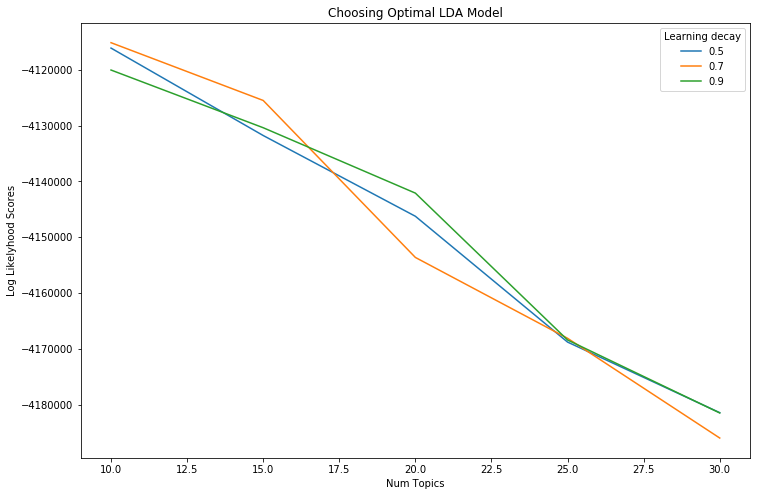

In [35]:
import matplotlib.pyplot as plt

# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = model.cv_results_['mean_test_score'][model.cv_results_['param_learning_decay']==0.5]
log_likelyhoods_7 = model.cv_results_['mean_test_score'][model.cv_results_['param_learning_decay']==0.7]
log_likelyhoods_9 = model.cv_results_['mean_test_score'][model.cv_results_['param_learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [36]:
#最佳话题模型
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -4115134.285913357


### 6. 如何查看每个文档的话题信息
LDA会给每个文档分配一个话题分布，其中概率最大的话题最能代表该文档

In [39]:
import numpy as np

# 构建文档-词频矩阵
lda_output = best_lda_model.transform(data_vectorized)

# 列名
topicnames = ["Topic" + str(i) 
              for i in range(best_lda_model.n_components)]

# 行索引名
docnames = ["Doc" + str(i) 
            for i in range(len(df.content))]

# 转化为pd.DataFrame
df_document_topic = pd.DataFrame(np.round(lda_output, 2), 
                                 columns=topicnames, 
                                 index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)


def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.sample(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc9466,0.04,0.03,0,0,0.1,0,0,0.59,0,0.24,7
Doc9657,0.74,0.09,0.08,0,0,0,0,0,0,0.09,0
Doc4364,0,0,0,0,0,0.54,0.18,0.2,0.07,0,5
Doc4722,0,0,0,0,0.61,0,0,0.39,0,0,4
Doc555,0.1,0,0.08,0,0,0.11,0.09,0.06,0,0.56,9
Doc5536,0.16,0.65,0,0,0,0,0,0,0.17,0,1
Doc1847,0,0,0,0,0.16,0,0.16,0.66,0,0,7
Doc8398,0,0,0.03,0.03,0,0,0,0,0,0.93,9
Doc567,0.33,0,0,0,0,0,0.65,0,0,0,6
Doc7315,0,0.27,0,0,0,0.04,0.25,0.06,0,0.38,9


##### 查看话题分布情况

In [40]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,2520
1,9,1832
2,6,1417
3,5,1223
4,1,1103
5,7,1079
6,4,1007
7,2,486
8,8,383
9,3,264


### 7.如何可视化LDA
pyLDAvis可视化话题教程  https://dwz.cn/gUmqUC1c

In [43]:
!pip3 install pyldavis

    100% |████████████████████████████████| 1.6MB 137kB/s ta 0:00:011
    100% |████████████████████████████████| 184kB 4.9MB/s ta 0:00:01
    100% |████████████████████████████████| 225kB 428kB/s ta 0:00:011
    100% |████████████████████████████████| 61kB 241kB/s ta 0:00:011
    100% |████████████████████████████████| 92kB 297kB/s ta 0:00:01
  Running setup.py install for pyldavis ... done
You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [45]:
import pyLDAvis
import pyLDAvis.sklearn

#在notebook中显示
pyLDAvis.enable_notebook()

#
panel = pyLDAvis.sklearn.prepare(best_lda_model, #训练好的lda模型
                                 data_vectorized,#训练库语料的词语特征空间（即Tfidfvecterizer或者CounterVecterizer）
                                 vectorizer)
panel

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.135775 -0.026085       1        1  15.321421
7     -0.113634  0.037698       2        1  14.482735
5     -0.099226  0.085089       3        1  13.378595
4     -0.049322  0.032909       4        1  13.187362
9      0.001965 -0.083429       5        1  11.268348
6      0.145791 -0.044006       6        1   9.452602
1     -0.082777 -0.191644       7        1   8.375484
2      0.062573  0.109453       8        1   5.928131
3      0.108699  0.048264       9        1   5.315535
8     -0.109844  0.031750      10        1   3.289787, topic_info=     Category          Freq          Term         Total  loglift  logprob
5436  Default   4060.000000           max   4060.000000  30.0000  30.0000
4846  Default   2237.000000           key   2237.000000  29.0000  29.0000
3728  Default   2797.000000           god   2797.000000  28.0000  28.0000
3593  Default   1991.000000          game   1991.000000  27.0000  27.0000
9374  Default   9001.000000           use   9001.000000  26.0000  26.0000
9733  Default   3057.000000        window   3057.000000  25.0000  25.0000
6063  Default  19390.000000           not  19390.000000  24.0000  24.0000
1297  Default   1782.000000           car   1782.000000  23.0000  23.0000
3325  Default   3104.000000          file   3104.000000  22.0000  22.0000
8781  Default   1530.000000          team   1530.000000  21.0000  21.0000
8539  Default  12282.000000       subject  12282.000000  20.0000  20.0000
5136  Default  13083.000000          line  13083.000000  19.0000  19.0000
6281  Default  11341.000000  organization  11341.000000  18.0000  18.0000
4659  Default    965.000000        israel    965.000000  17.0000  17.0000
8274  Default   1865.000000         space   1865.000000  16.0000  16.0000
3852  Default   1709.000000           gun   1709.000000  15.0000  15.0000
9303  Default   5595.000000    university   5595.000000  14.0000  14.0000
1480  Default   1458.000000          chip   1458.000000  13.0000  13.0000
1494  Default   1615.000000     christian   1615.000000  12.0000  12.0000
4660  Default    807.000000       israeli    807.000000  11.0000  11.0000
6789  Default   7124.000000          post   7124.000000  10.0000  10.0000
498   Default   1318.000000      armenian   1318.000000   9.0000   9.0000
6702  Default   1470.000000          play   1470.000000   8.0000   8.0000
3755  Default   1958.000000    government   1958.000000   7.0000   7.0000
6704  Default   1005.000000        player   1005.000000   6.0000   6.0000
2917  Default    861.000000    encryption    861.000000   5.0000   5.0000
520   Default   7654.000000       article   7654.000000   4.0000   4.0000
2713  Default   2526.000000         drive   2526.000000   3.0000   3.0000
4149  Default   4993.000000          host   4993.000000   2.0000   2.0000
6026  Default   4761.000000          nntp   4761.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
7684  Topic10     83.012635        rutger     99.764995   3.2305  -6.4548
4718  Topic10     92.897687     jerusalem    117.724511   3.1775  -6.3423
588   Topic10     95.636921         athen    124.305755   3.1522  -6.3132
1351  Topic10    163.435318      catholic    267.738555   2.9208  -5.7774
9679  Topic10    256.105025       western    518.347982   2.7093  -5.3282
8852  Topic10    117.135910     territory    173.574247   3.0211  -6.1104
6520  Topic10    203.707824         peace    440.624457   2.6428  -5.5571
6193  Topic10    171.329222          ohio    378.018427   2.6230  -5.7302
6743  Topic10    212.260865        policy    579.324038   2.4103  -5.5160
4945  Topic10    201.422585          land    548.645639   2.4123  -5.5684
9303  Topic10    555.798783    university   5595.946788   1.1050  -4.5534
8539  Topic10    719.776074       subject  12282.578728   0.5774  -4.2948
520   Topic10    573.512537       article   7654.4890

### 8. 如何查看话题的特征词组
每个话题都是由带有权重的词组进行表征，是一个二维空间

In [50]:
# 话题-关键词矩阵（Topic-Keyword Matrix）
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# 重新分配dataframe中的列名和行索引名
df_topic_keywords.columns = vectorizer.get_feature_names() #训练集的词语空间的词表
df_topic_keywords.index = topicnames  

df_topic_keywords

,aaa,aaron,abandon,abbreviation,abc,aberystwyth,abide,abiding,ability,able,...,zinc,zion,zionism,zionist,zip,zisfein,zone,zoology,zoom,zubov
Topic0,0.100004,7.734544,0.100040,0.100011,0.100087,0.100082,0.100001,0.100000,45.472677,255.277166,...,0.100018,0.100002,0.100000,0.100000,115.793299,0.100000,17.873953,0.100003,29.790688,0.100000
Topic1,60.319070,11.766506,0.100012,0.100048,110.389100,0.100003,0.100001,0.100000,42.672644,56.887329,...,0.100000,0.100001,0.100000,0.100000,0.100003,0.100000,77.331725,0.100000,0.100142,16.099999
Topic2,0.100000,0.100011,0.100003,0.100001,1.032251,0.100000,16.208385,10.677979,48.045209,78.238743,...,0.100000,0.100003,0.100000,0.100001,0.100007,0.100000,1.778982,0.100007,0.100001,0.100000
Topic3,0.100012,0.100019,6.713461,0.100073,0.100578,0.100000,0.100001,0.100000,6.358062,36.453899,...,26.094356,0.100000,0.100000,0.100000,6.430241,0.100007,0.100004,0.100002,13.035653,0.100000
Topic4,0.100020,0.393385,6.801215,0.100074,0.674650,0.100003,0.100018,0.100008,57.245199,173.689046,...,0.100054,0.719786,0.100001,0.100050,0.100047,32.099991,2.620045,0.100015,0.100019,0.100000
Topic5,0.100001,13.459259,14.376899,0.124744,0.100008,0.100000,0.100061,0.100037,69.625875,114.743435,...,0.100000,0.100062,0.100002,1.054015,1.349059,0.100000,0.255016,0.100001,0.100003,0.100000
Topic6,0.100005,0.100022,5.877339,18.074923,11.502834,1.147566,0.100002,0.100016,0.335060,71.481893,...,0.100003,0.100002,0.100001,0.100000,47.500459,0.100000,0.100028,69.547424,0.100025,0.100000
Topic7,0.100010,30.336387,26.730971,0.100001,5.900461,0.100001,60.991504,1.521951,15.740294,123.081683,...,0.100000,2.606244,0.100004,2.262188,12.426834,0.100000,27.190803,0.100001,0.100005,0.100000
Topic8,0.100002,12.493586,0.100050,0.100065,0.100002,0.100002,0.100006,0.100000,0.100014,13.575064,...,0.105515,8.973899,69.099991,74.983746,0.100004,0.100000,58.308452,0.100000,1.473417,0.100000
Topic9,2.880874,33.516282,0.100011,0.100061,0.100029,12.052343,0.100021,0.100009,16.404966,94.571742,...,0.100053,0.100001,0.100000,0.100000,0.100046,0.100001,1.440992,13.652546,0.100046,0.100000


### 9.如何获得每个话题的最重要的n个特征词

In [54]:
# 显示每个话题最重要的n个词语
def show_topics(vectorizer=vectorizer, lda_model=lda_model, top_n=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    #话题-词语权重矩阵
    for topic_weights in lda_model.components_:
        #获得权重最大的top_n词语的权重向量
        top_keyword_locs = (-topic_weights).argsort()[:top_n]
        #在keywords中找到对于的关键词
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, 
                             lda_model=best_lda_model, 
                             top_n=10)     #最重要的10个词语   


df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,have,use,line,can,subject,window,not,file,organization,get
Topic 1,have,game,team,play,line,year,win,subject,will,organization
Topic 2,key,have,use,will,chip,can,not,encryption,clipper,system
Topic 3,use,have,not,can,will,window,widget,line,when,should
Topic 4,have,not,would,will,people,there,can,get,make,think
Topic 5,not,have,max,god,say,can,there,write,christian,would
Topic 6,line,subject,organization,post,space,university,host,have,nntp,mail
Topic 7,have,not,people,there,say,gun,would,armenian,write,when
Topic 8,israel,israeli,not,have,subject,organization,line,article,university,write
Topic 9,have,line,subject,organization,write,get,car,article,not,can


### 10. 如何对新文本进行话题预测
给训练好的模型输入新文本，预测该文本的话题

In [99]:
# Define function to predict topic for a given text document.
#nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(texts, nlp=nlp):
    #清洗数据，如提出空格、邮箱、剔除无意义的词语、保留信息量比较大的词性
    cleaned_texts = []
    for text in texts:
        cleaned_texts.append(clean_text(text))
    
    doc_term_matrix = vectorizer.transform(cleaned_texts)

    #LDA transform
    topic_term_prob_matrix = best_lda_model.transform(doc_term_matrix)
    
    #话题
    topic_index = np.argmax(topic_term_prob_matrix)
    topic_word = df_topic_keywords.iloc[topic_index, :].values.tolist()
    
    return topic_index, topic_word, topic_term_prob_matrix

#预测
mytext = ["Some text about christianity and bible"]
topic_index, topic_word, topic_term_prob_matrix = predict_topic(mytext)
print("该文本的所属的话题是Topic",topic_index)
print("该话题的特征词 ", topic_word)
print("特征词的权重分布情况 ", topic_term_prob_matrix)

该文本的所属的话题是Topic 5
该话题的特征词  ['not', 'have', 'max', 'god', 'say', 'can', 'there', 'write', 'christian', 'would']
特征词的权重分布情况  [[0.02500225 0.025      0.02500547 0.02500543 0.02500001 0.7749855
  0.02500082 0.02500052 0.025      0.025     ]]
